# Star Type Classification
#### Dataset downloaded from [here](https://www.kaggle.com/datasets/brsdincer/star-type-classification).
## Goals:
- Gain experience using multi label dataset 
- Build a classififer that has an accuracy of 80 or higher
### Dataset Features:
- Temperature -- K<br>
- L -- L/Lo<br>
- R -- R/Ro<br>
- AM -- Mv<br>
- Color -- General Color of Spectrum<br>
- Spectral_Class -- O, B, A, F, G, K, M / SMASS - https://en.wikipedia.org/wiki/Asteroid_spectral_types<br>
- Type -- Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , Super Giants, Hyper Giants<br>

## Contents:
* [Preprocessing](#Preprocessing)
* [Histogram Visualisation](#Histogram-Visualisation)
* [Model Selection and Testing](#Model-Selection-and-Testing)
* [Parameter Tuning](#Parameter-Tuning)
* [Final Testing](#Final-Testing)

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('stars.csv')

# Dropping for ease
df.drop(df[df['Spectral_Class'] == 'G'].index, inplace=True)

In [3]:
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     239 non-null    int64  
 1   L               239 non-null    float64
 2   R               239 non-null    float64
 3   A_M             239 non-null    float64
 4   Color           239 non-null    object 
 5   Spectral_Class  239 non-null    object 
 6   Type            239 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 14.9+ KB


In [5]:
df.nunique()

Temperature       227
L                 207
R                 215
A_M               227
Color              17
Spectral_Class      6
Type                6
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

In [54]:
# Split dataset into train/test data (test set will not be used until after model testing)
X, X_test, y, y_test = train_test_split(df.drop(['Type'], axis=1), df['Type'], test_size=0.20, random_state=42)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X: (191, 6)
Shape of y: (191,)
Shape of X_test: (48, 6)
Shape of y_test: (48,)


### Preprocessing

In [55]:
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Removes warnings in current job (RandomizedSearch CV)
warnings.filterwarnings("ignore")
# Removes warnings in spawned jobs
os.environ['PYTHONWARNINGS']='ignore'
# Set plot size
plt.rcParams['figure.figsize'] = [15, 6]
# Set palette
sns.set_palette('pastel')

In [56]:
# Sort features into categorical/numerical lists
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(include=np.number).columns

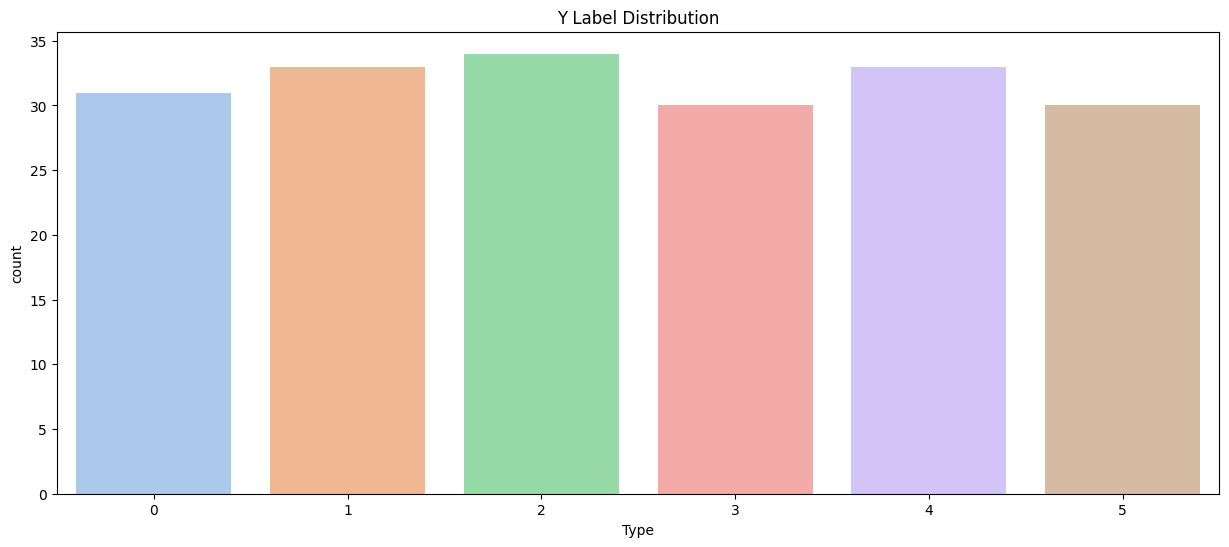

In [57]:
# Check target label distribution 
plt.title('Y Label Distribution')
sns.countplot(x=y)
plt.show()

# Red Dwarf - 0
# Brown Dwarf - 1
# White Dwarf - 2
# Main Sequence - 3
# Super Giants - 4
# Hyper Giants - 5

In [59]:
def format_colours(value):
    valid_colours = ['Red', 'Blue', 'Yellow', 'White', 'Orange',]
    abb = {'Yellowish': 'Yellow', 'Whitish': 'White', 'Bluish': 'Blue', 'Redish': 'Red'}
    
    if value not in valid_colours:
        # Add hyphen to allow split
        value += '-'
        # Use first colour after splitting string
        new_value = value.replace(' ', '-').split('-')[0]
        
        # Check if new value is valid
        if new_value in abb.keys():
            return abb[new_value]
        elif new_value in valid_colours:
            return new_value
        else:
            return 'Unknown'
            
    return value
    

def albedo_conversion(value):
    s = df['Spectral_Class'].unique()
    albedo_keys = {'AMK': 'Moderate', 'BFG': 'Low', 'O': 'None'}
    
    # Return albedo corresponding to value
    for spec, albedo in albedo_keys.items():
        if value in spec:
            return albedo
        

def onehot_encode(dataframe):
    # Creates list of categorical features in dataframe
    columns = dataframe.select_dtypes(include='object').columns
    # Adds prefix to new column title
    prefixes = [x.upper() for x in columns]
    # Creates copy of dataframe to modify
    temp_df = dataframe.copy()
    
    # Loop through each column/prefix and add encoded columns to exisiting dataframe
    for feature, prefix in zip(columns, prefixes):
        encoded = pd.get_dummies(temp_df[feature], prefix=prefix)
        temp_df = pd.concat([temp_df, encoded], axis=1)
    
    # Drop original categorical columns
    temp_df.drop(columns, axis=1, inplace=True)
    return temp_df

        
# Group value in range of two numbers within list range and return index pos of lowest number
# --------------------------------------------------------------------------------------------------------------------
def group_temperature(value):
    temp_range = [x for x in range(0, 60000, 3000)]
    for i in range(len(temp_range) - 1):
        if value >= temp_range[i] and value < temp_range[i+1]:
            return i


def group_am(value):
    am_range = [x for x in range(-30, 30, 5)]
    for i in range(len(am_range) - 1):
        if value >= am_range[i] and value < am_range[i+1]:
            return i
        

def group_L(value):
    L_range = [x for x in range(0, 1000000, 100000)]
    for i in range(len(L_range) - 1):
        if value >= L_range[i] and value < L_range[i+1]:
            return i

def group_R(value):
    R_range = [x for x in range(0, 5000, 100)]
    for i in range(len(R_range) - 1):
        if value >= R_range[i] and value < R_range[i+1]:
            return i
# --------------------------------------------------------------------------------------------------------------------

def preprocessing(dataframe):
    # Create copy of dataframe
    dataframe = dataframe.copy()
    
    # Clean 'Color' column
    dataframe['Color'] = dataframe['Color'].apply(format_colours)
    # Add 'Albedo' column 
    dataframe['Albedo'] = dataframe['Spectral_Class'].apply(albedo_conversion)
    # Group Temperature, A_M, L, R values to reduce high cardinality
    dataframe['Temperature'] = dataframe['Temperature'].apply(group_temperature)
    dataframe['A_M'] = dataframe['A_M'].apply(group_am)
    dataframe['L'] = dataframe['L'].apply(group_L)
    dataframe['R'] = dataframe['R'].apply(group_R)
    
    # Drop remaining NaN rows
    dataframe = dataframe.dropna()
    
    return dataframe

In [60]:
print(f"Before preprocessing: {X.shape}")
X = preprocessing(X)
print(f"After preprocessing: {X.shape}")

Before preprocessing: (191, 6)
After preprocessing: (191, 7)


### Histogram Visualisation

In [61]:
# Create new df after preprocessing with target label included
label_df = pd.concat([X, y], axis=1)

# Create separate dataframes for each label and add them to list
df_cache = []
for value in y.unique():
    temp_df = label_df[label_df['Type'] == value]
    df_cache.append(temp_df)

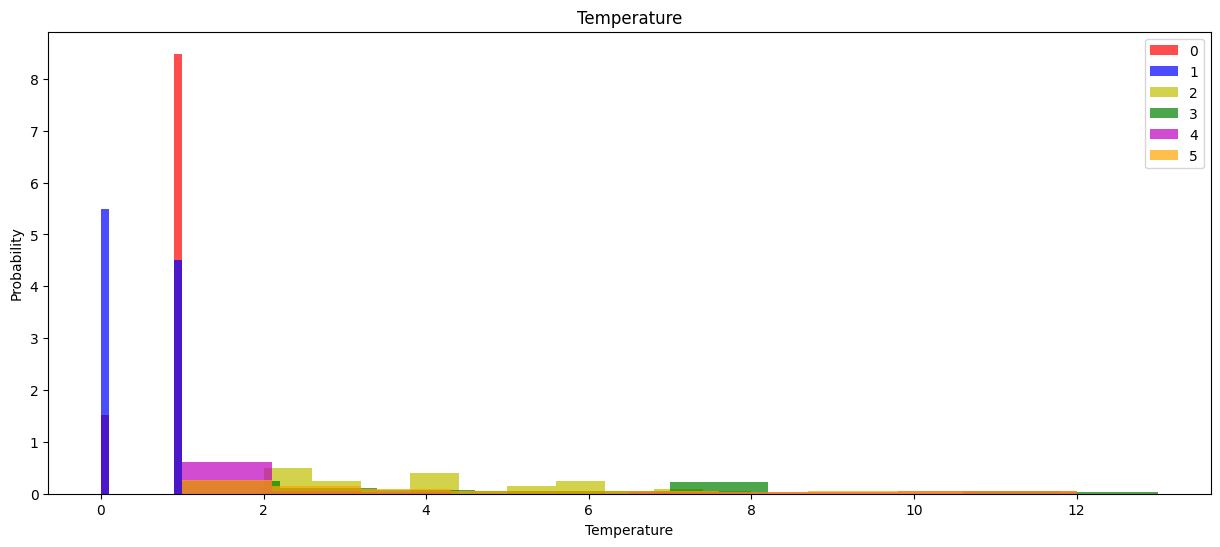

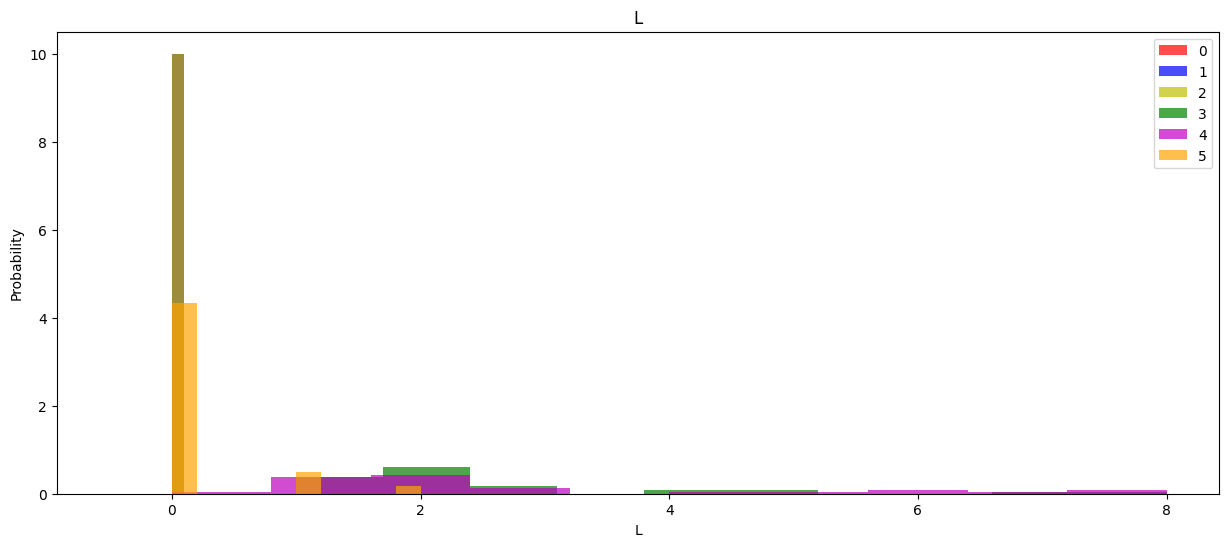

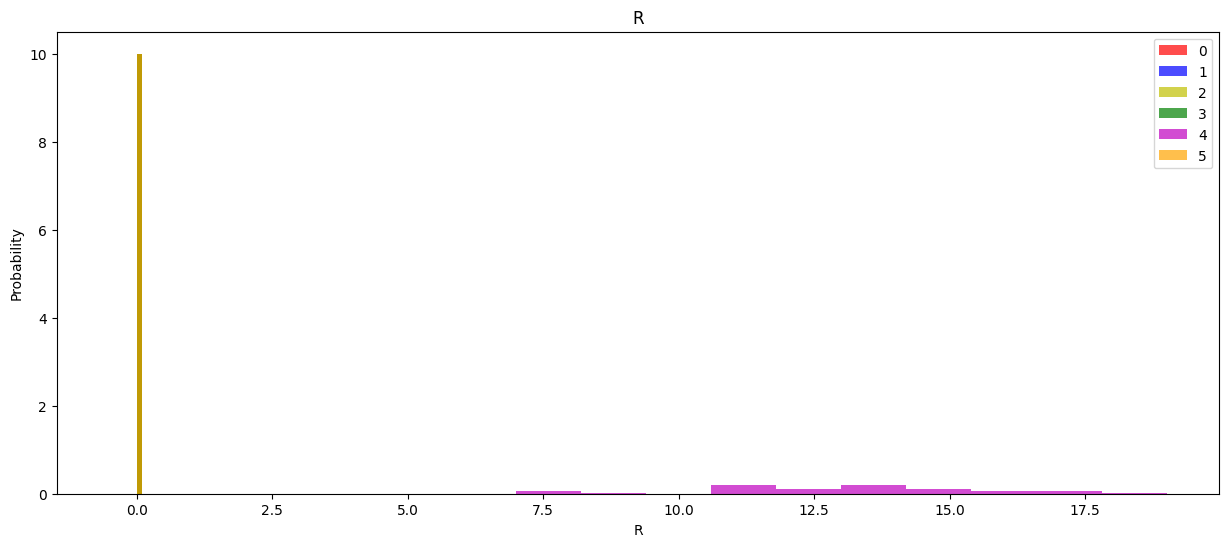

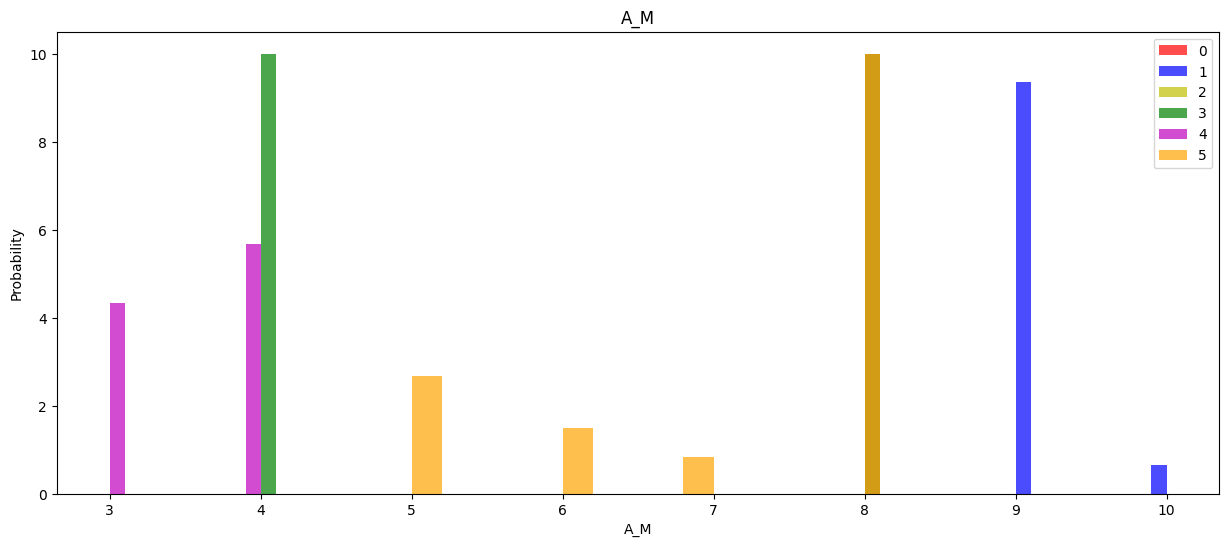

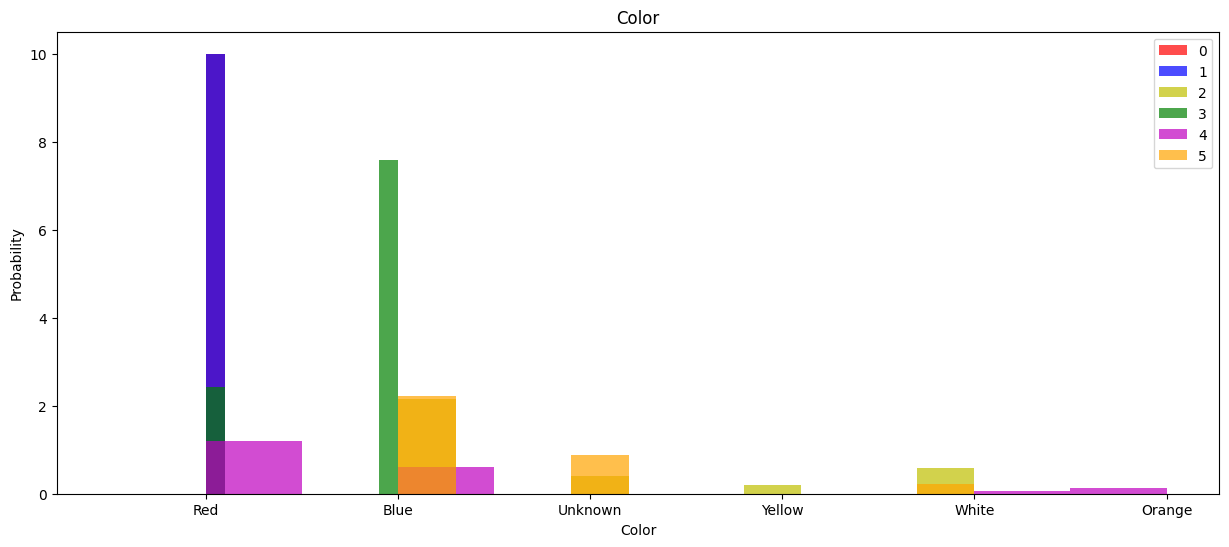

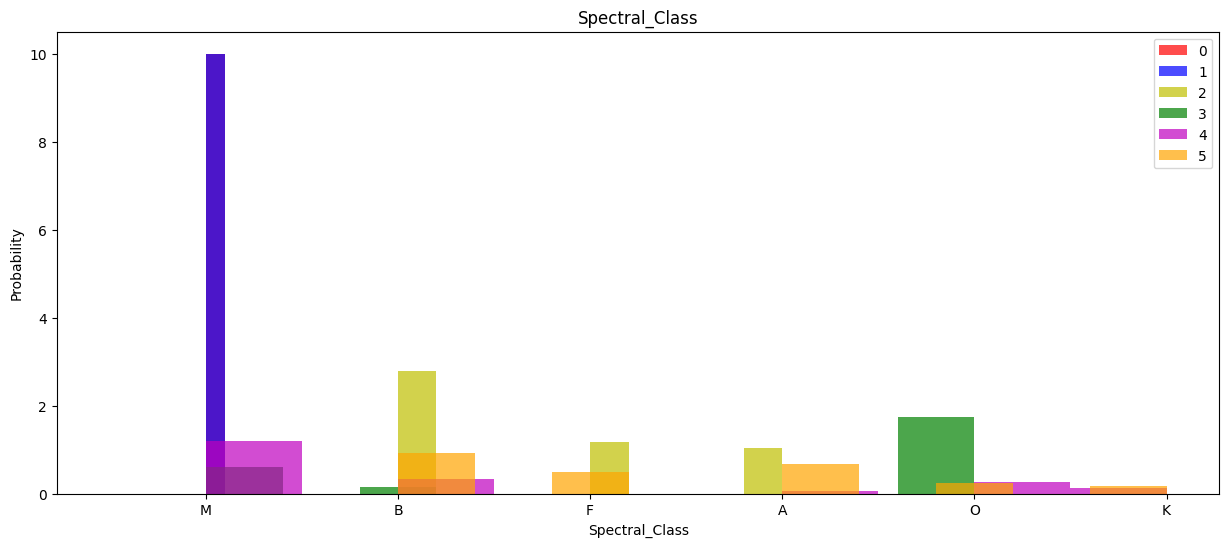

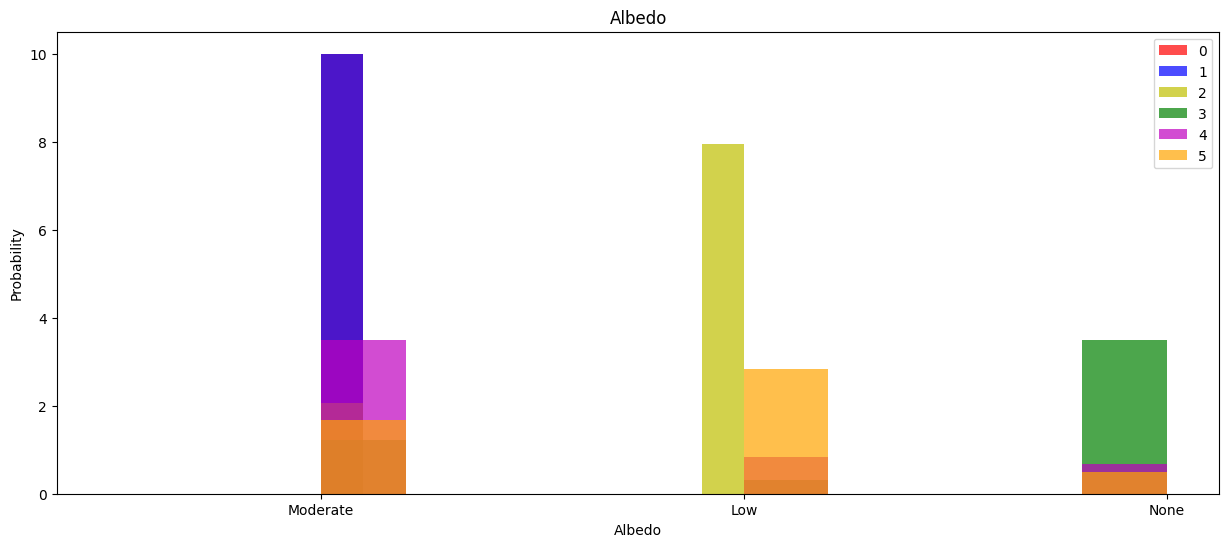

In [62]:
# Plot histograms
colours = ['r', 'b', 'y', 'g', 'm', 'orange']

for feature in X.columns:
    for index, d in enumerate(df_cache):
        plt.title(feature)
        plt.hist(d[feature], density=True, alpha=0.7, color=colours[index], label=index)
        plt.xlabel(feature)
        plt.ylabel('Probability')
        plt.legend()
    
    plt.show()

### Model Selection and Testing

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
s = StandardScaler()

# OneHot/Standardize X
X = onehot_encode(X)
X_train, y_train = pd.DataFrame(s.fit_transform(X), columns=X.columns), y

In [65]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [66]:
# Store models in a dictionary
models = {
    'RandomForest': RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'GradientBoost': GradientBoostingClassifier(),
    'LogisticReg': LogisticRegression()
}

RANDOMFOREST:
Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
Roc Auc Score 1.0


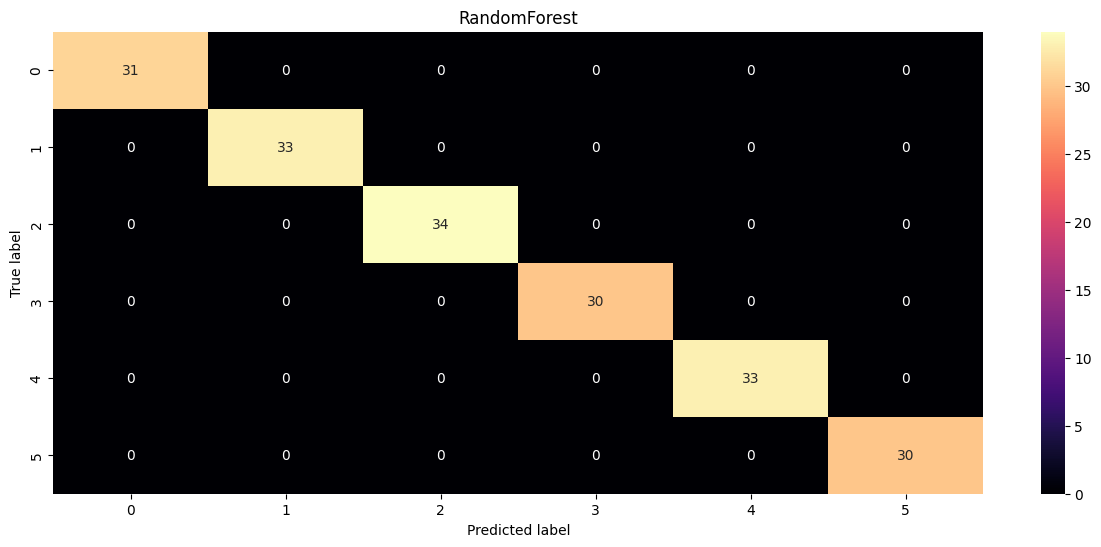

XGB:
Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
Roc Auc Score 1.0


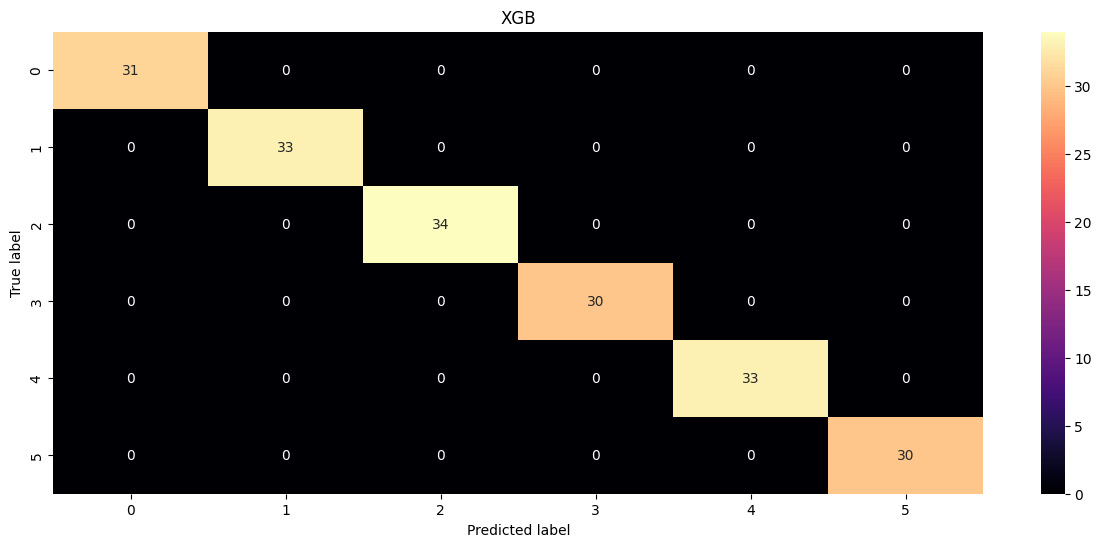

GRADIENTBOOST:
Accuracy score: 1.0
Recall score: 1.0
Precision score: 1.0
Roc Auc Score 1.0


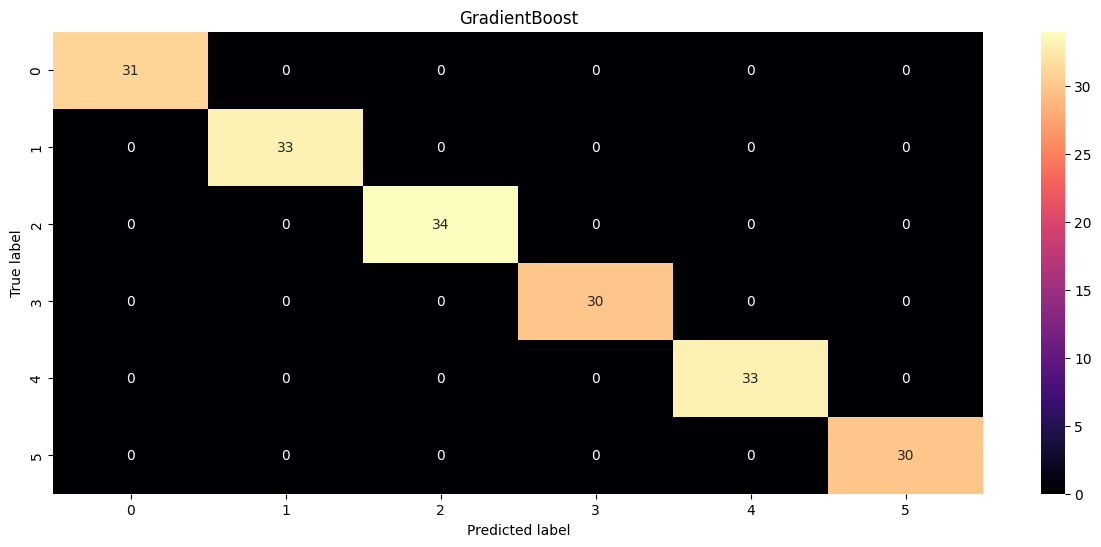

LOGISTICREG:
Accuracy score: 0.9842931937172775
Recall score: 0.9843434343434344
Precision score: 0.9840389784946236
Roc Auc Score 0.999803126000154


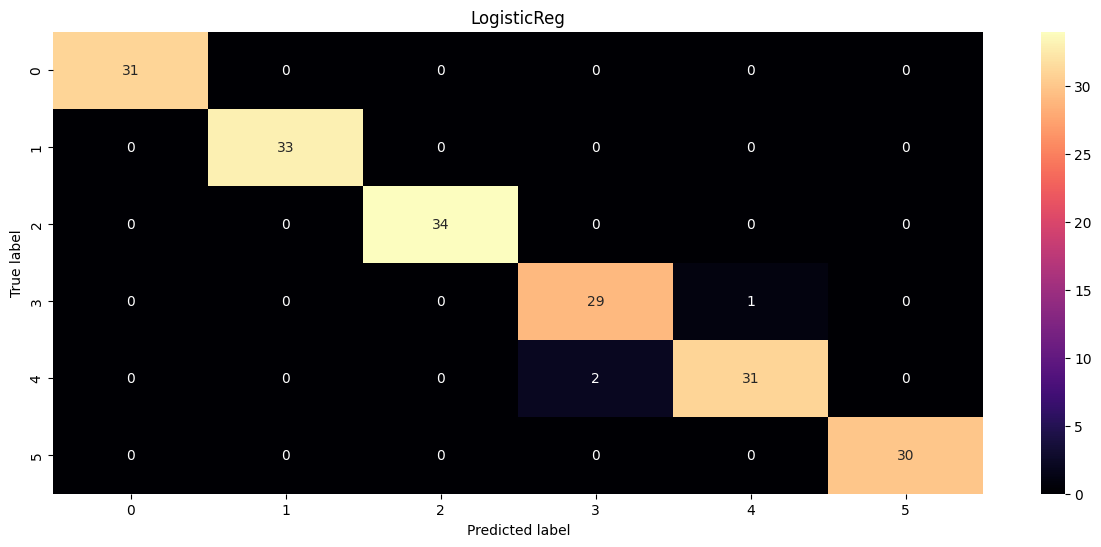

In [67]:
# Run baseline metrics 
# Sine the dataset is small, I'm using X_train for baseline predictions which is NOT recommended)

for name, model in models.items():
    print(f"{name.upper()}:")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    y_probas = model.predict_proba(X_train)
    
    acc_score = accuracy_score(y_train, y_pred)
    rec_score = recall_score(y_train, y_pred, average='macro')
    pre_score = precision_score(y_train, y_pred, average='macro')
    roc_score = roc_auc_score(y_train, y_probas, multi_class='ovr')
    
    # Print each metric
    print(f"Accuracy score: {acc_score}")
    print(f"Recall score: {rec_score}")
    print(f"Precision score: {pre_score}")
    print(f"Roc Auc Score {roc_score}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_train, y_pred)
    plt.title(name)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Parameter Tuning

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
model_params = {
    # XBG parameters
    'XGB': {
        'learning_rate': [0.05, 0.10, 0.15, 0.30],
        'max_depth': np.arange(1, 16, 5),
        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
    },

    # RandomForest parameters
    'RandomForest': {
        'criterion': ['entropy', 'gini'],
        'max_depth': range(2, 21, 5),
        'max_features': ['auto', 'sqrt', 'log2'],
        'n_estimators': [90, 100, 130, 150]
    },

    # LogisticReg parameters 
    'LogisticReg': {
        'C': np.logspace(-9, 9, 30),
        'penalty': ['l2', 'l1', 'None', 'elasticnet'],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'max_iter': [10000]
    },
    
    # GradientBooster parameters
    'GradientBoost': {
        'learning_rate': [1, 0.5, 0.01],
        'n_estimators': [1, 2, 4, 6, 100],
        'max_depth': range(5, 9),
        'max_features': list(range(1, X_train.shape[1]))
    }
}

In [70]:
fitted_models = {}

# Run GSCV on each model and compare to baseline metrics
for name, model in models.items():
    print(f"Fitting {name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=model_params[name],
        scoring='accuracy',
        n_jobs=-1,
        cv=5,
        verbose=True
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store optimal models in fitted_models
    fitted_models[name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_,
        'cv': grid_search.cv_results_
    }

print(f"\nFitting complete!")

Fitting RandomForest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting XGB...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Fitting GradientBoost...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Fitting LogisticReg...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Fitting complete!


In [71]:
# Get accuracy score for each model
for name, d in fitted_models.items():
    print(f"{name} score: {d['score']}")

RandomForest score: 1.0
XGB score: 1.0
GradientBoost score: 1.0
LogisticReg score: 0.9948717948717949


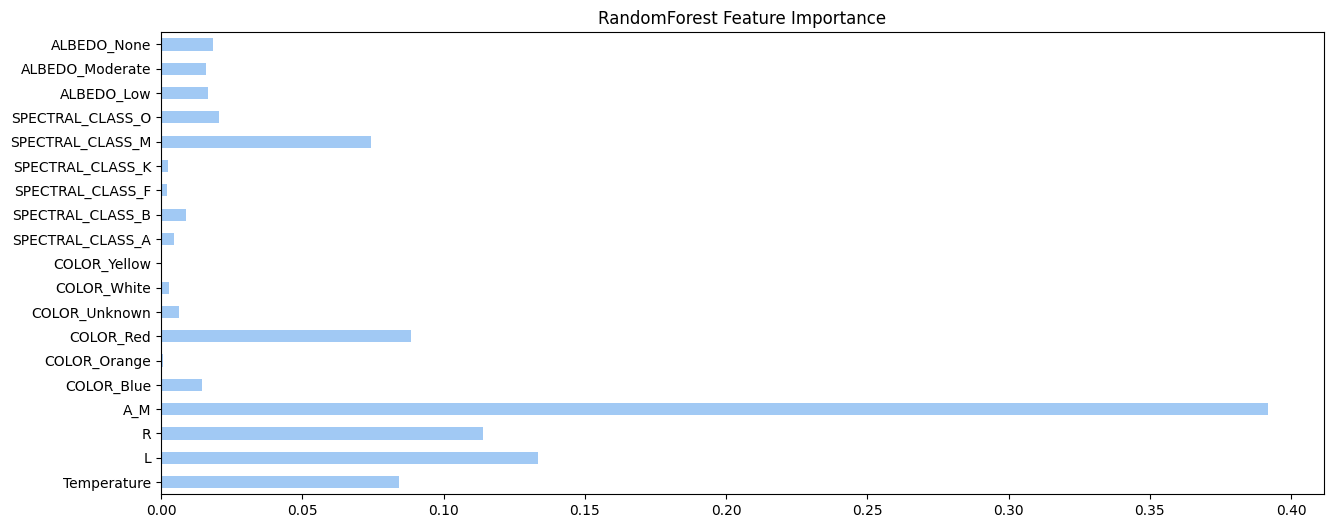

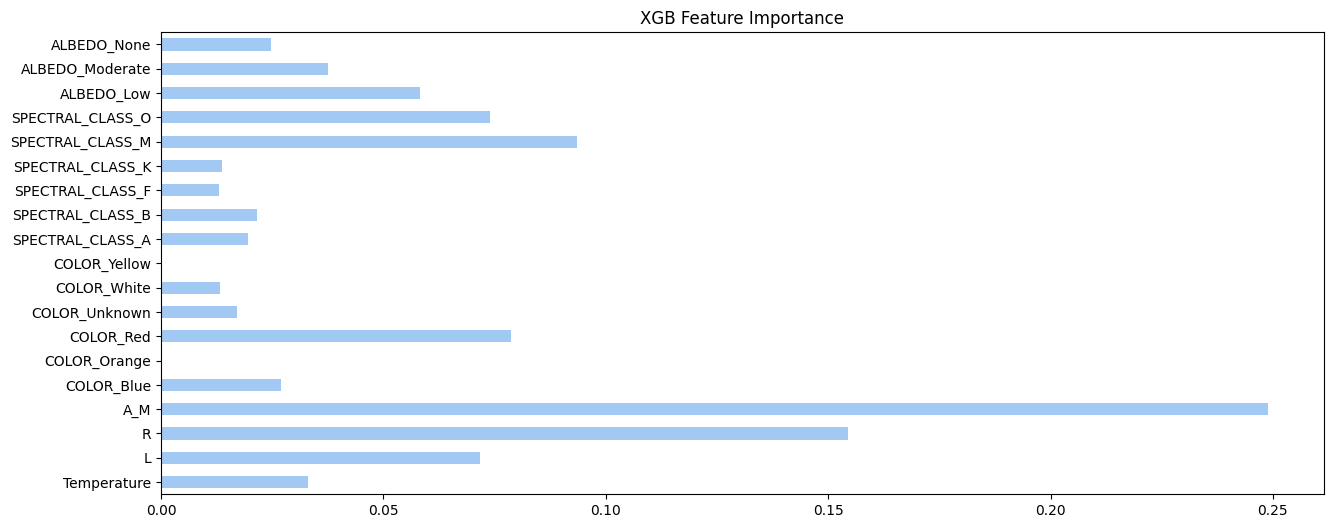

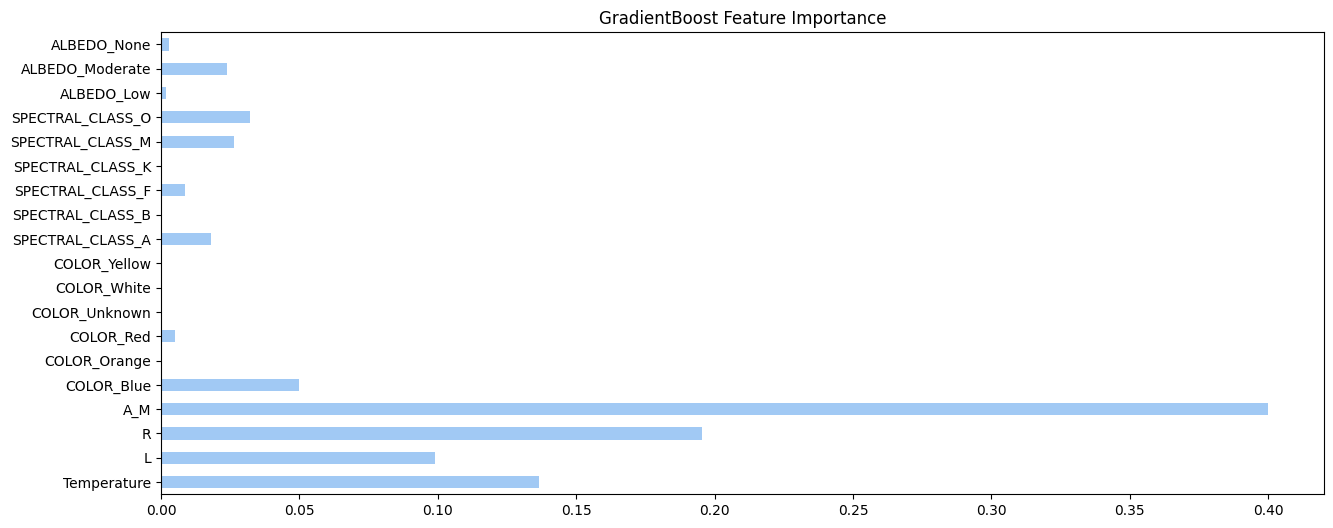

In [72]:
def plot_feature_importance(importances, feature_names, model):
    pd.Series(importances, index=feature_names).plot(kind='barh')
    plt.title(f"{model} Feature Importance")
    plt.show()


for name, d in fitted_models.items():
    if name != 'LogisticReg':
        feature_names = X_train.columns
        importances = d['model'].feature_importances_
        plot_feature_importance(importances, feature_names, name)

### Final Testing

In [73]:
import pickle

In [74]:
def save_model(model):
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)

def load_model(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [75]:
# Save model
chosen_clf = fitted_models['RandomForest']['model']

In [76]:
# Preprocessing steps
final_test = preprocessing(X_test)
final_test = onehot_encode(final_test)
final_test = pd.DataFrame(s.transform(final_test), columns=final_test.columns)

In [77]:
# Load model
final_clf = load_model('model.pkl')
final_clf

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto',
                       n_estimators=90)

In [78]:
final_clf.fit(X_train, y_train)
test_pred = final_clf.predict(final_test)

In [79]:
# run metrics on final model
print(f"Accuracy score on test set: {accuracy_score(y_test, test_pred)}")
print(f"Recall score on test set: {recall_score(y_test, test_pred, average='micro')}")
print(f"Precision score on test set: {precision_score(y_test, test_pred, average='micro')}")

Accuracy score on test set: 1.0
Recall score on test set: 1.0
Precision score on test set: 1.0
